##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [27]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [28]:
test_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Initially this returns a dataset of (text, label pairs):

In [30]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())


text:  [b'Watched both parts twice. Enjoyed the story and enjoyed seeing an older Patrick Swayze as the hero. He was very believable as the hunter Alan Quartermaine and certainly bested the performance of Richard Chamberlain. I do admit that I would have preferred seeing someone else as the "Lady in Distress". Alison Doody should stick with modern and not period pieces. She didn\'t have the look of the woman of the 1800\'s. The rest of the cast were terrific and followed the plotlines very well. I am glad to see that the actors of this generation are not afraid to try on different characters and are not afraid to be seen as getting older. Age is inevitable, but let\'s not hide from it. A man at 50+ can be much sexier (and , Patrick truly is sexy) then a green youth, no matter how pretty. Hoorah for character lines to go along with a great smile.'
 b'In 1925, childhood friends Marie Dressler (as Maggie Warren) and Polly Moran (as Lizzie Praskins) oversee the wedding of their children, A

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [35]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])
train_dataset.take(1).element_spec

texts:  [b"Like all Carnosaur movies, this is a joke. The way the dinosaurs move, reminds me of when my sister plays with her dolls, because they cannot be any stiffer or more fake-looking than they were.<br /><br />The plot had no sense whatsoever. I mean, first they're on a bus, then in a warehouse then, all of a sudden, they're on a boat. And let's be serious, does it make sense that a couple of dinosaurs can stay together on a van, or on a ship? I thought dinosaurs were the biggest animals, and now they can fit on a moving van. It sounds stupid even when you think about it.<br /><br />The only reason for which I gave this a 3, is because it's still entertaining. I found it better than the first one (haven't watched the second yet). Just, don't rent it. I saw it on TV and it's a good thing I did because I wouldn't have wanted to waste money renting it."
 b"This was a nice attempt at something but it is too pretentious and boring to rise above it's low budget trappings. The use of vi

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [32]:
example

<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'Watched both parts twice. Enjoyed the story and enjoyed seeing an older Patrick Swayze as the hero. He was very believable as the hunter Alan Quartermaine and certainly bested the performance of Richard Chamberlain. I do admit that I would have preferred seeing someone else as the "Lady in Distress". Alison Doody should stick with modern and not period pieces. She didn\'t have the look of the woman of the 1800\'s. The rest of the cast were terrific and followed the plotlines very well. I am glad to see that the actors of this generation are not afraid to try on different characters and are not afraid to be seen as getting older. Age is inevitable, but let\'s not hide from it. A man at 50+ can be much sexier (and , Patrick truly is sexy) then a green youth, no matter how pretty. Hoorah for character lines to go along with a great smile.',
       b'In 1925, childhood friends Marie Dressler (as Maggie Warren) and Polly Moran (as Lizzi

In [33]:
encoded_example = encoder(example)[:3].numpy()
encoder(example)[:3]

<tf.Tensor: shape=(3, 889), dtype=int64, numpy=
array([[284, 191, 510, ...,   0,   0,   0],
       [  8,   1,   1, ...,   0,   0,   0],
       [ 11,  20,   7, ...,   0,   0,   0]], dtype=int64)>

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This is a modest, character driven comedy, filmed in Brazil on a low budget. The premise is familiar, the same as in the 1950's Danny Kaye movie **On the Double**: someone who, as a joke, does an impression of a Famous Person then is dragooned to impersonate the Person for real.<br /><br />The contrast between the two leads is highly effective. Raul Julia as the German-Paradorian secret policeman, is tall, cool, menacing and Latin. He sports a deliberately obvious blond dye job. Richard Dreyfus, animated, short, New York Jewish, is funny and sympathetic. There are many references and inside jokes about show business.<br /><br />The setting is clearly modeled on Paraguay. Paraguay was indeed ruled from the early fifties to the late eighties by Gen. Alfredo Stroessner, an unelected military dictator whose father had emigrated from Germany. But writer/director Mazurszky reveals his ignorance of local conditions when he paints Parador/Paraguay as a typical Latin American tyran

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [14]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[-0.01330366]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [15]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 149ms/step
[-0.01330792]


Compile the Keras model to configure the training process:

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

## Train the model

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 175ms/step - loss: 0.6164 - accuracy: 0.5939 - val_loss: 0.4548 - val_accuracy: 0.7927
Epoch 2/10
391/391 [==============================] - 50s 128ms/step - loss: 0.4016 - accuracy: 0.8170 - val_loss: 0.3711 - val_accuracy: 0.8375
Epoch 3/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3491 - accuracy: 0.8502 - val_loss: 0.3448 - val_accuracy: 0.8453
Epoch 4/10
391/391 [==============================] - 53s 136ms/step - loss: 0.3252 - accuracy: 0.8618 - val_loss: 0.3362 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 49s 126ms/step - loss: 0.3119 - accuracy: 0.8686 - val_loss: 0.3256 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3094 - accuracy: 0.8704 - val_loss: 0.3261 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3031 - accuracy: 0.8716 - val_loss: 0.3223 - val_ac

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 57ms/step - loss: 0.3318 - accuracy: 0.8628
Test Loss: 0.3318251967430115
Test Accuracy: 0.8627600073814392


(0.0, 0.6324389860033989)

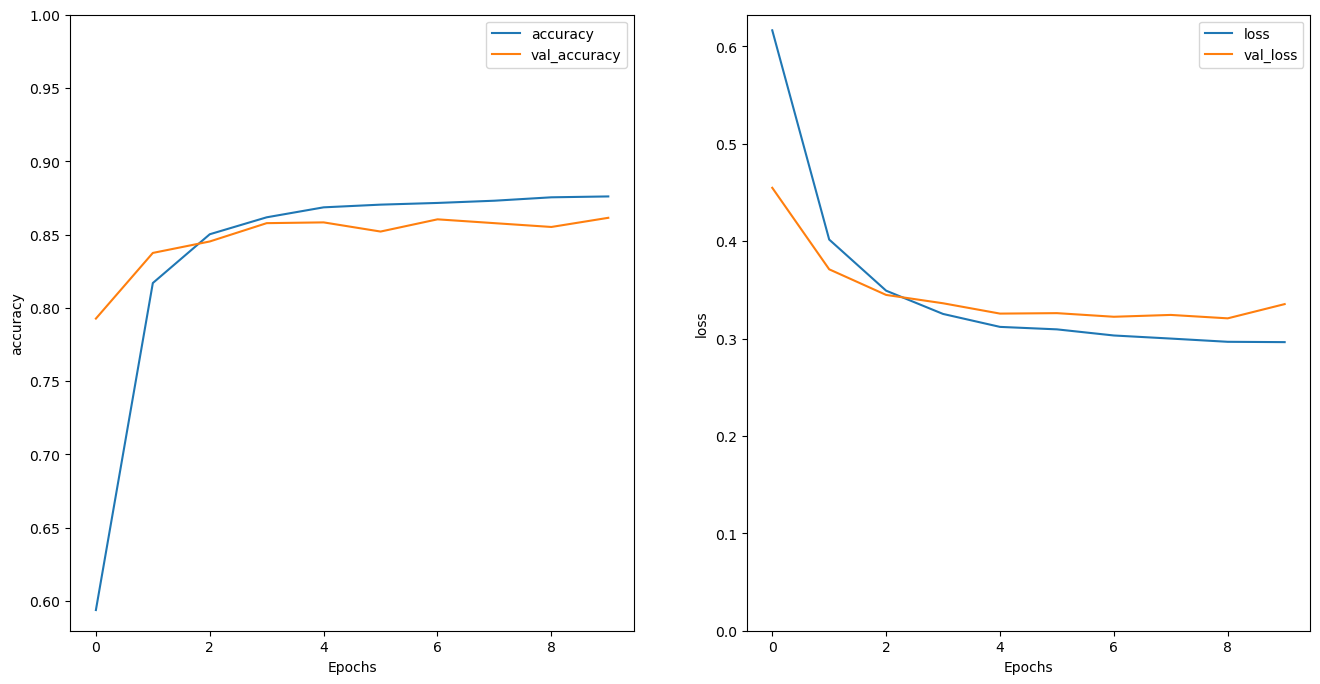

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 2s 2s/step


array([[0.89754534]], dtype=float32)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 99s 222ms/step - loss: 0.6432 - accuracy: 0.5724 - val_loss: 0.4616 - val_accuracy: 0.7948
Epoch 2/10
391/391 [==============================] - 84s 213ms/step - loss: 0.4024 - accuracy: 0.8254 - val_loss: 0.3635 - val_accuracy: 0.8417
Epoch 3/10
391/391 [==============================] - 86s 220ms/step - loss: 0.3421 - accuracy: 0.8550 - val_loss: 0.3461 - val_accuracy: 0.8370
Epoch 4/10
391/391 [==============================] - 83s 211ms/step - loss: 0.3214 - accuracy: 0.8632 - val_loss: 0.3276 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 84s 214ms/step - loss: 0.3145 - accuracy: 0.8670 - val_loss: 0.3235 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 89s 227ms/step - loss: 0.3094 - accuracy: 0.8693 - val_loss: 0.3243 - val_accuracy: 0.8552
Epoch 7/10
391/391 [==============================] - 87s 222ms/step - loss: 0.3062 - accuracy: 0.8688 - val_loss: 0.3281 - val_ac

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 44s 113ms/step - loss: 0.3157 - accuracy: 0.8600
Test Loss: 0.3156709671020508
Test Accuracy: 0.8599600195884705


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.8304839]]


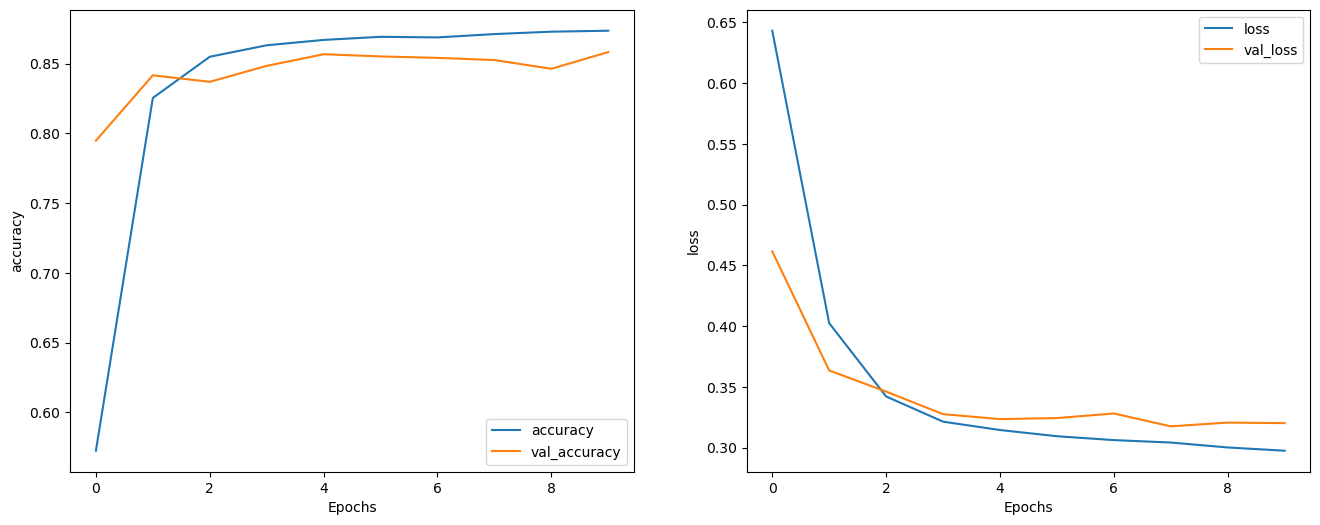

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
